In [1]:
%load_ext autoreload
%autoreload 2
import pylab as plt
import torch
import numpy as np
from tqdm.auto import tqdm

## Nested sampling 

In [19]:
def get_directions(B, D):
    """This function generates a minibatch of D-dimensional random directions."""
    t = torch.randn(B, D)
    l = (t**2).sum(axis=-1)**0.5
    n = t/l.unsqueeze(-1)
    return n

In [20]:
def get_slice_sample_points(B, S):
    """This function generates a minibatch of S slice sample positions."""
    hard_bounds = torch.tensor([-1., 1.]).unsqueeze(0).repeat((B,1))
    current_bounds = hard_bounds.clone()
    L = torch.empty((B, S))
    for i in range(S):
        x = torch.rand(B)*(current_bounds[:,1]-current_bounds[:,0])+current_bounds[:,0]
        L[:,i] = x
        current_bounds[x<0,0] = x[x<0]
        current_bounds[x>0,1] = x[x>0]
    return L

In [40]:
def gen_new_samples(X_seeds, logl_fn, logl_th, num_steps = 10, max_step_size = 1., samples_per_slice = 20):
    """This function generates new samples within the likelihodo constraint logl_fn > log_th."""
    B, D = X_seeds.shape
    C = torch.zeros(B)  # counter for accepted points
    X = X_seeds.clone()
    logl = torch.ones(B)*(-np.inf)
    for i in range(num_steps):
        N = get_directions(B, D)
        L = get_slice_sample_points(B, S = samples_per_slice)*max_step_size
        dX = N.unsqueeze(-2)*L.unsqueeze(-1)
        pX = X.unsqueeze(-2) + dX # proposals
        logl_prop = logl_fn(pX)
        accept_matrix = logl_prop > logl_th
        idx = torch.argmax(accept_matrix.int(), dim=1)
        nX = torch.stack([pX[i][idx[i]] for i in range(B)], dim=0)
        logl_selected = torch.stack([logl_prop[i][idx[i]] for i in range(B)], dim=0)
        accept_any = (accept_matrix.sum(dim=-1)>0)
        X[accept_any] = nX[accept_any]
        logl[accept_any] = logl_selected[accept_any]
        C[accept_any] += 1
    return X[C==num_steps], logl[C==num_steps]

In [72]:
def nested_sampling(X_init, logl_fn, logl_th_max = -1.0, max_steps = 100000, num_batch_samples = 100):
    """Run nested sampling, staring with X_init live points."""
    NLP, D = X_init.shape
    X_live = X_init.clone()
    L_live = logl_fn(X_live)
    B = min(num_batch_samples, NLP)  # Number of samples generated simultanously
    V = 1.  # initial volume is set to 1.
    samples = []
    logl_th = -np.inf
    
    pbar = tqdm(range(max_steps))
    for i in pbar:
        pbar.set_description("logl_th %.1f" % logl_th)
        idx_batch = np.random.choice(range(NLP), B, replace = True)
        X_batch = X_live[idx_batch]
        logl_th = L_live.min()
        if logl_th > logl_th_max:  # Stop sampling once maxmimum threshold is reached
            break
        X_new, L_new = gen_new_samples(X_batch, logl, logl_th, num_steps = 10)
        for i in range(len(X_new)):
            if L_new[i] > L_live.min():
                idx_min = np.argmin(L_live)
                Lmin = L_live[idx_min]
                samples.append([V, Lmin.item()*1., 1*X_live[idx_min].numpy()])
                L_live[idx_min] = L_new[i]*1.0
                X_live[idx_min] = X_new[i]*1.0
                V *= (1-1/NLP)  # Volume estimate per sample
            else:
                break
    return X_live, L_live

In [98]:
def grow_live_points(X_init, logl_fn, logl_th_max = -1.0, num_batch_samples = 100, num_samples = 10000):
    NLP, D = X_init.shape
    X_live = X_init.clone()
    L_live = logl_fn(X_live)
    B = min(num_batch_samples, NLP)  # Number of samples generated simultanously
    while len(X_live) < num_samples:
        NLP = len(X_live)
        idx_batch = np.random.choice(range(NLP), B, replace = True)
        X_batch = X_live[idx_batch]
        X_new, L_new = gen_new_samples(X_batch, logl, logl_th_max, num_steps = 10)
        X_live = torch.cat([X_live, X_new])
        L_live = torch.cat([L_live, L_new])
    return X_live, L_live

## Tests

### Plotting live points

  0%|          | 0/100000 [00:00<?, ?it/s]

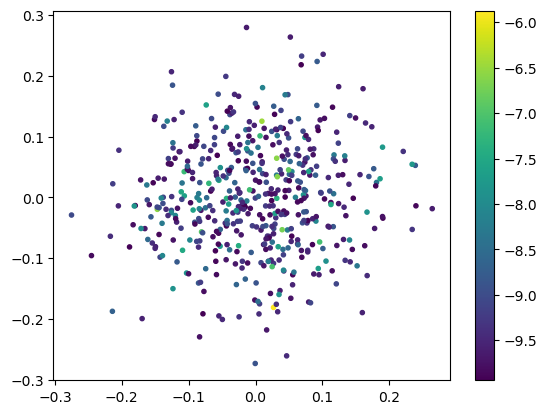

In [105]:
def logl(u):
    ret = (-0.5*(u[..., :]**2)/0.1**2).sum(axis=-1)
    return ret
X_init = torch.randn(500, 22)
X_live, L_live = nested_sampling(X_init, logl, logl_th_max = -10., num_batch_samples = 50)
plt.scatter(X_live[:,0], X_live[:,1], marker='.', c = L_live)
plt.colorbar()

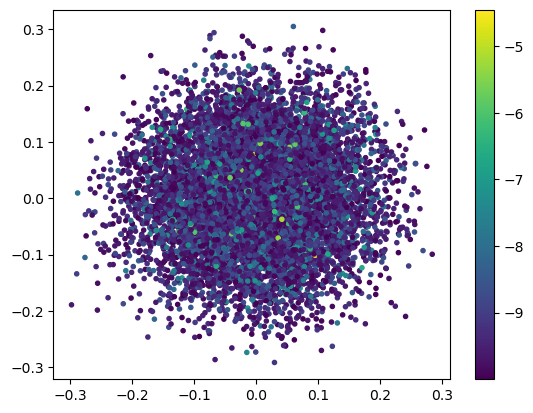

In [106]:
X, L = grow_live_points(X_live, logl, num_samples = 10000, logl_th_max = -10.)
plt.scatter(X[:,0], X[:,1], marker='.', c = L)
plt.colorbar()